# Classification With Convolutional Neural Network (CIFAR10 Data)

## Import

In [1]:
import torchvision
from torchvision.datasets import CIFAR10 
from torchvision import transforms as T

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader , random_split
import torch.backends.cudnn as cudnn

from torchmetrics import Accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## CIFAR Dataset

In [2]:
transform_train = T.Compose([T.RandomCrop(32 , padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                         std=[0.2470, 0.2435, 0.2616])])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                         std=[0.2470, 0.2435, 0.2616])])

In [3]:
train_set = CIFAR10(root='./CIFAR10' , train=True , download=True , transform=transform_train)
test_set = CIFAR10(root='./CIFAR10' , train=False , download=True , transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0,1,2])

tensor([0.4914, 0.4822, 0.4465])

In [5]:
torch.FloatTensor(train_set.data/255.).std(dim=[0,1,2])

tensor([0.2470, 0.2435, 0.2616])

## DataLoader

In [4]:
train_dataloader = DataLoader(train_set , batch_size= 64 , shuffle=True)
test_dataloader = DataLoader(test_set , batch_size= 32)

In [5]:
x , y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


## Visualize

In [8]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

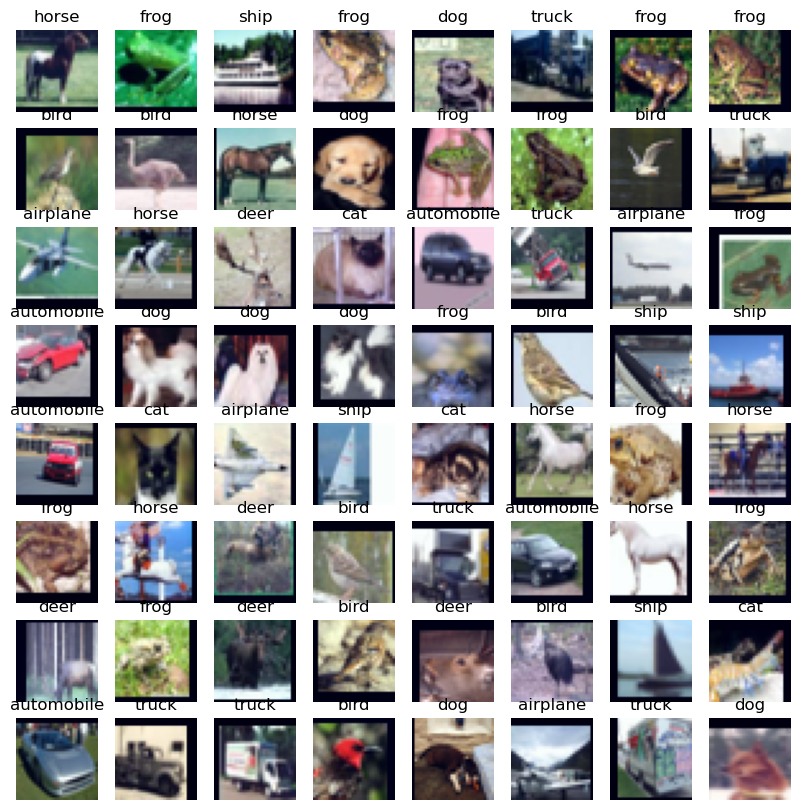

In [9]:
batch = next(iter(train_dataloader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

## Model 

In [10]:
def conv3x3_bn_af(in_channels , out_channels):
    module = nn.Sequential(nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=3 , padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU())
    return module

In [11]:
def CNN():
    network = nn.Sequential(conv3x3_bn_af(3 , 64), #32x32
                          conv3x3_bn_af(64 , 64),
                          nn.MaxPool2d(2 , 2), #16x16

                          conv3x3_bn_af(64 , 128),
                          conv3x3_bn_af(128 , 128),
                          nn.MaxPool2d(2 , 2), #8x8

                          conv3x3_bn_af(128,256),
                          conv3x3_bn_af(256,256),
                          nn.MaxPool2d(2 , 2), #4x4

                          conv3x3_bn_af(256 , 512),
                          conv3x3_bn_af(512 , 512),
                          nn.AdaptiveAvgPool2d(output_size=(1 , 1)), #1x1

                          nn.Flatten(),
                          nn.Linear(512 , 10) # classifier
                        )                   
    return network

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Utils

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Functions

In [15]:
def train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=10).to(device)
  with tqdm(train_dataloader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [16]:
def validation(model, test_dataloader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Efficient Way For Set Hyperparams

### Check Forward Path

In [17]:
x_batch, y_batch = next(iter(train_dataloader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3699, device='cuda:0', grad_fn=<NllLossBackward0>)


### Check Backward Path

In [18]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [19]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:01<00:00, 49.12batch/s, accuracy=55.9, loss=1.21]


### Select Best Learning Rate

In [20]:
num_epochs = 2
for lr in [0.1, 0.01 , 0.001]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 782/782 [00:31<00:00, 24.76batch/s, accuracy=72.3, loss=0.788]



LR=0.01


Epoch 1: 100%|██████████| 782/782 [00:31<00:00, 24.63batch/s, accuracy=65.7, loss=0.963]



LR=0.001


Epoch 1: 100%|██████████| 782/782 [00:31<00:00, 24.79batch/s, accuracy=43, loss=1.59]  

### Small Grid

In [21]:
num_epochs = 5

for lr in [0.04 , 0.06 , 0.08 , 0.1 , 0.12]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)   
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
    print()

LR=0.04, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.52batch/s, accuracy=82.8, loss=0.497]



LR=0.04, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.70batch/s, accuracy=83.2, loss=0.491]



LR=0.04, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.81batch/s, accuracy=83, loss=0.497]  



LR=0.06, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.53batch/s, accuracy=82.8, loss=0.492]



LR=0.06, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 23.76batch/s, accuracy=83.3, loss=0.482]



LR=0.06, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 24.39batch/s, accuracy=83.2, loss=0.487]



LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 23.90batch/s, accuracy=82.9, loss=0.494]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:33<00:00, 23.20batch/s, accuracy=83.3, loss=0.486]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.64batch/s, accuracy=83.2, loss=0.486]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.97batch/s, accuracy=83.1, loss=0.486]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 24.04batch/s, accuracy=83, loss=0.488]  



LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.46batch/s, accuracy=83.3, loss=0.484]



LR=0.12, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 24.23batch/s, accuracy=82.8, loss=0.494]



LR=0.12, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 25.12batch/s, accuracy=83, loss=0.492]  



LR=0.12, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 25.19batch/s, accuracy=83.2, loss=0.488]

## Train Model

In [22]:
model = CNN().to(device)

In [23]:
lr = 0.06
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [24]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [25]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_dataloader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_dataloader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:31<00:00, 25.02batch/s, accuracy=55.4, loss=1.23]


Valid: Loss = 3.507, Acc = 0.3205



Epoch 1: 100%|██████████| 782/782 [00:31<00:00, 25.15batch/s, accuracy=72.8, loss=0.776]


Valid: Loss = 0.982, Acc = 0.678



Epoch 2: 100%|██████████| 782/782 [00:30<00:00, 25.30batch/s, accuracy=77.7, loss=0.639]


Valid: Loss = 1.636, Acc = 0.5304



Epoch 3: 100%|██████████| 782/782 [00:31<00:00, 25.20batch/s, accuracy=80.9, loss=0.547]


Valid: Loss = 0.687, Acc = 0.7701



Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 25.21batch/s, accuracy=83.1, loss=0.491]


Valid: Loss = 0.8678, Acc = 0.7279



Epoch 5: 100%|██████████| 782/782 [00:31<00:00, 24.92batch/s, accuracy=84.6, loss=0.447]


Valid: Loss = 1.677, Acc = 0.622



Epoch 6: 100%|██████████| 782/782 [00:31<00:00, 24.88batch/s, accuracy=85.6, loss=0.413]


Valid: Loss = 0.5482, Acc = 0.8202



Epoch 7: 100%|██████████| 782/782 [00:31<00:00, 25.12batch/s, accuracy=86.9, loss=0.38] 


Valid: Loss = 1.073, Acc = 0.6794



Epoch 8: 100%|██████████| 782/782 [00:30<00:00, 25.24batch/s, accuracy=87.9, loss=0.349]


Valid: Loss = 0.773, Acc = 0.761



Epoch 9: 100%|██████████| 782/782 [00:30<00:00, 25.34batch/s, accuracy=88.4, loss=0.33] 


Valid: Loss = 0.7004, Acc = 0.7904



Epoch 10: 100%|██████████| 782/782 [00:31<00:00, 25.09batch/s, accuracy=89.3, loss=0.311]


Valid: Loss = 0.6279, Acc = 0.8162



Epoch 11: 100%|██████████| 782/782 [00:30<00:00, 25.41batch/s, accuracy=90.1, loss=0.286]


Valid: Loss = 0.5121, Acc = 0.8351



Epoch 12: 100%|██████████| 782/782 [00:30<00:00, 25.28batch/s, accuracy=90.4, loss=0.271]


Valid: Loss = 0.6556, Acc = 0.8072



Epoch 13: 100%|██████████| 782/782 [00:30<00:00, 25.29batch/s, accuracy=91.1, loss=0.257]


Valid: Loss = 0.5263, Acc = 0.8406



Epoch 14: 100%|██████████| 782/782 [00:31<00:00, 25.14batch/s, accuracy=91.4, loss=0.242]


Valid: Loss = 0.4352, Acc = 0.8666



## Visualize

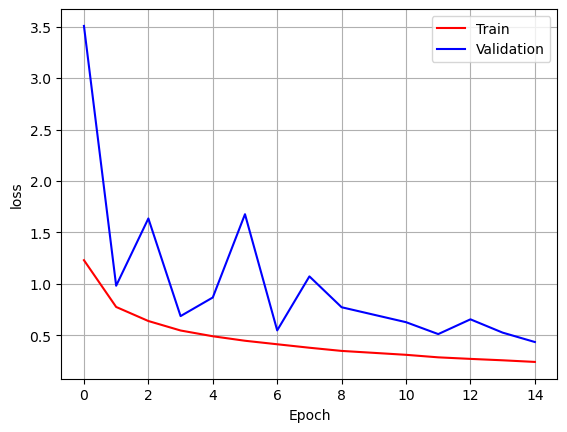

In [26]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

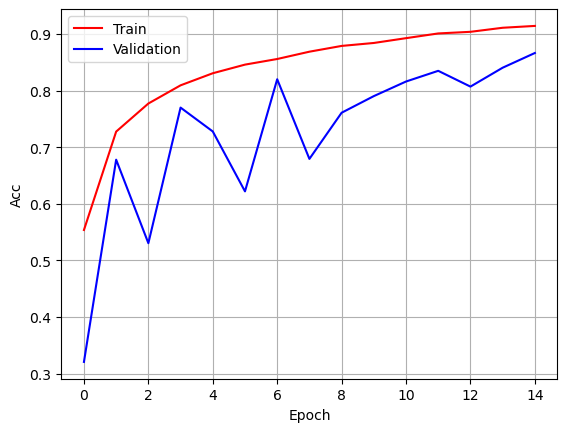

In [27]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [6]:
print(train_set.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## Test Model (Single Prediction)

True Label: ship
Predicted: ship, confidence=0.9978


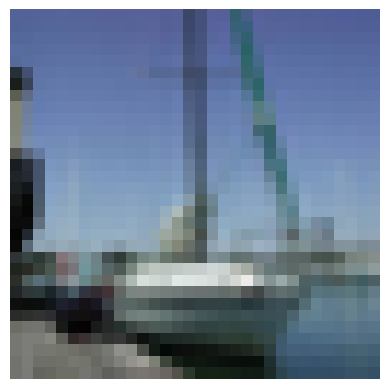

In [13]:
import torch.nn.functional as F
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("model.pt", weights_only=False)
model.to(device)
model.eval()

idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}

idx = random.randint(0, len(test_set)-1)
img, true_label = test_set[idx]

img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    probabilities = torch.softmax(output, dim=1)
    pred_idx = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, pred_idx].item()

print(f"True Label: {idx_to_class[true_label]}")
print(f"Predicted: {idx_to_class[pred_idx]}, confidence={confidence:.4f}")

plt.imshow(test_set.data[idx])
plt.axis("off")
plt.show()
